# DOWNLOAD THE DATASET

In [4]:
import GEOparse
import pandas as pd

import os

# Create necessary directories
os.makedirs('./data', exist_ok=True)
os.makedirs('./results', exist_ok=True)
os.makedirs('./figures', exist_ok=True)

# Download GSE147507 from GEO
gse = GEOparse.get_GEO(geo="GSE147507", destdir="./data/")

# Examine the dataset
print("Dataset info:")
print(f"Title: {gse.metadata['title'][0]}")
print(f"Samples: {len(gse.gsms)}")
print("\nSample names:")
for gsm_name, gsm in gse.gsms.items():
    print(f"{gsm_name}: {gsm.metadata['title'][0]}")

05-Feb-2026 19:54:57 DEBUG utils - Directory ./data/ already exists. Skipping.
05-Feb-2026 19:54:57 INFO GEOparse - File already exist: using local version.
05-Feb-2026 19:54:57 INFO GEOparse - Parsing ./data/GSE147507_family.soft.gz: 
05-Feb-2026 19:54:57 DEBUG GEOparse - DATABASE: GeoMiame
05-Feb-2026 19:54:57 DEBUG GEOparse - SERIES: GSE147507
05-Feb-2026 19:54:57 DEBUG GEOparse - PLATFORM: GPL18573
05-Feb-2026 19:54:59 DEBUG GEOparse - PLATFORM: GPL28369
05-Feb-2026 19:54:59 DEBUG GEOparse - SAMPLE: GSM4432378
05-Feb-2026 19:54:59 DEBUG GEOparse - SAMPLE: GSM4432379
05-Feb-2026 19:54:59 DEBUG GEOparse - SAMPLE: GSM4432380
05-Feb-2026 19:54:59 DEBUG GEOparse - SAMPLE: GSM4432381
05-Feb-2026 19:54:59 DEBUG GEOparse - SAMPLE: GSM4432382
05-Feb-2026 19:54:59 DEBUG GEOparse - SAMPLE: GSM4432383
05-Feb-2026 19:54:59 DEBUG GEOparse - SAMPLE: GSM4432384
05-Feb-2026 19:54:59 DEBUG GEOparse - SAMPLE: GSM4432385
05-Feb-2026 19:54:59 DEBUG GEOparse - SAMPLE: GSM4432386
05-Feb-2026 19:54:59 DEB

Dataset info:
Title: Transcriptional response to SARS-CoV-2 infection
Samples: 110

Sample names:
GSM4432378: Series1_NHBE_Mock_1
GSM4432379: Series1_NHBE_Mock_2
GSM4432380: Series1_NHBE_Mock_3
GSM4432381: Series1_NHBE_SARS-CoV-2_1
GSM4432382: Series1_NHBE_SARS-CoV-2_2
GSM4432383: Series1_NHBE_SARS-CoV-2_3
GSM4432384: Series2_A549_Mock_1
GSM4432385: Series2_A549_Mock_2
GSM4432386: Series2_A549_Mock_3
GSM4432387: Series2_A549_SARS-CoV-2_1
GSM4432388: Series2_A549_SARS-CoV-2_2
GSM4432389: Series2_A549_SARS-CoV-2_3
GSM4432390: Series3_A549_Mock_1
GSM4432391: Series3_A549_Mock_2
GSM4432392: Series3_A549_RSV_1
GSM4432393: Series3_A549_RSV_2
GSM4432394: Series4_A549_Mock_1
GSM4432395: Series4_A549_Mock_2
GSM4432396: Series4_A549_IAV_1
GSM4432397: Series4_A549_IAV_2
GSM4462336: Series5_A549_Mock_1
GSM4462337: Series5_A549_Mock_2
GSM4462338: Series5_A549_Mock_3
GSM4462339: Series5_A549_SARS-CoV-2_1
GSM4462340: Series5_A549_SARS-CoV-2_2
GSM4462341: Series5_A549_SARS-CoV-2_3
GSM4462342: Series6_

In [5]:
# Check how data is stored in this dataset
first_sample = list(gse.gsms.values())[0]
print("Sample metadata keys:", first_sample.metadata.keys())
print("\nChecking for supplementary files:")
print("Supplementary files:", first_sample.metadata.get('supplementary_file', 'None'))
print("\nData table type:", type(first_sample.table))
print("Columns:", first_sample.table.columns.tolist() if hasattr(first_sample.table, 'columns') else 'No columns')

# Check the GSE level
print("\nGSE supplementary files:")
print(gse.metadata.get('supplementary_file', 'None'))

Sample metadata keys: dict_keys(['title', 'geo_accession', 'status', 'submission_date', 'last_update_date', 'type', 'channel_count', 'source_name_ch1', 'organism_ch1', 'taxid_ch1', 'characteristics_ch1', 'molecule_ch1', 'extract_protocol_ch1', 'description', 'data_processing', 'platform_id', 'contact_name', 'contact_laboratory', 'contact_department', 'contact_institute', 'contact_address', 'contact_city', 'contact_state', 'contact_zip/postal_code', 'contact_country', 'instrument_model', 'library_selection', 'library_source', 'library_strategy', 'relation', 'supplementary_file_1', 'series_id', 'data_row_count'])

Checking for supplementary files:
Supplementary files: None

Data table type: <class 'pandas.core.frame.DataFrame'>
Columns: []

GSE supplementary files:
['ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE147nnn/GSE147507/suppl/GSE147507_RawReadCounts_Ferret.tsv.gz', 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE147nnn/GSE147507/suppl/GSE147507_RawReadCounts_Human.tsv.gz']


# Load and Prepare the Data

In [6]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import gzip
import shutil
import os

# Create data directory if it doesn't exist
os.makedirs('./data', exist_ok=True)

# Download and extract the raw counts file
print("Downloading raw count data...")
url = "ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE147nnn/GSE147507/suppl/GSE147507_RawReadCounts_Human.tsv.gz"
local_gz = "./data/raw_counts.tsv.gz"
local_tsv = "./data/raw_counts.tsv"

# Only download if file doesn't exist
if not os.path.exists(local_tsv):
    print("  - Downloading from NCBI...")
    urllib.request.urlretrieve(url, local_gz)

    print("  - Extracting file...")
    # Unzip the file
    with gzip.open(local_gz, 'rb') as f_in:
        with open(local_tsv, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print("  - Download complete!")
else:
    print("  - File already exists, skipping download")

# Now load the data
print("\nLoading expression data...")
expr_df = pd.read_csv(local_tsv, sep='\t', index_col=0)

print(f"✓ Expression matrix shape: {expr_df.shape}")
print(f"\n✓ Column names (first 5 samples):\n{expr_df.columns.tolist()[:5]}")
print(f"\n✓ First few rows:\n{expr_df.head()}")

# Create sample info
sample_info = []
for col in expr_df.columns:
    # More specific matching - avoid double-counting
    if 'Mock' in col:
        condition = 'Mock'
    elif 'SARS-CoV-2' in col or 'SARS' in col:
        condition = 'Infected'
    else:
        condition = 'Unknown'
    sample_info.append({'Sample': col, 'Condition': condition})

sample_df = pd.DataFrame(sample_info)
print(f"\n✓ Sample conditions:")
print(sample_df['Condition'].value_counts())

# Save
expr_df.to_csv('./data/raw_expression.csv')
sample_df.to_csv('./data/sample_info.csv', index=False)
print("\n✓ Data saved successfully!")

  - File already exists, skipping download

Loading expression data...
✓ Expression matrix shape: (21797, 78)

✓ Column names (first 5 samples):
['Series1_NHBE_Mock_1', 'Series1_NHBE_Mock_2', 'Series1_NHBE_Mock_3', 'Series1_NHBE_SARS-CoV-2_1', 'Series1_NHBE_SARS-CoV-2_2']

✓ First few rows:
         Series1_NHBE_Mock_1  Series1_NHBE_Mock_2  Series1_NHBE_Mock_3  \
DDX11L1                    0                    0                    0   
WASH7P                    29                   24                   23   
FAM138A                    0                    0                    0   
FAM138F                    0                    0                    0   
OR4F5                      0                    0                    0   

         Series1_NHBE_SARS-CoV-2_1  Series1_NHBE_SARS-CoV-2_2  \
DDX11L1                          0                          0   
WASH7P                          34                         19   
FAM138A                          0                          0   
FAM

# Quality Control & Normalization

Genes after filtering: 15427
QC plots saved!


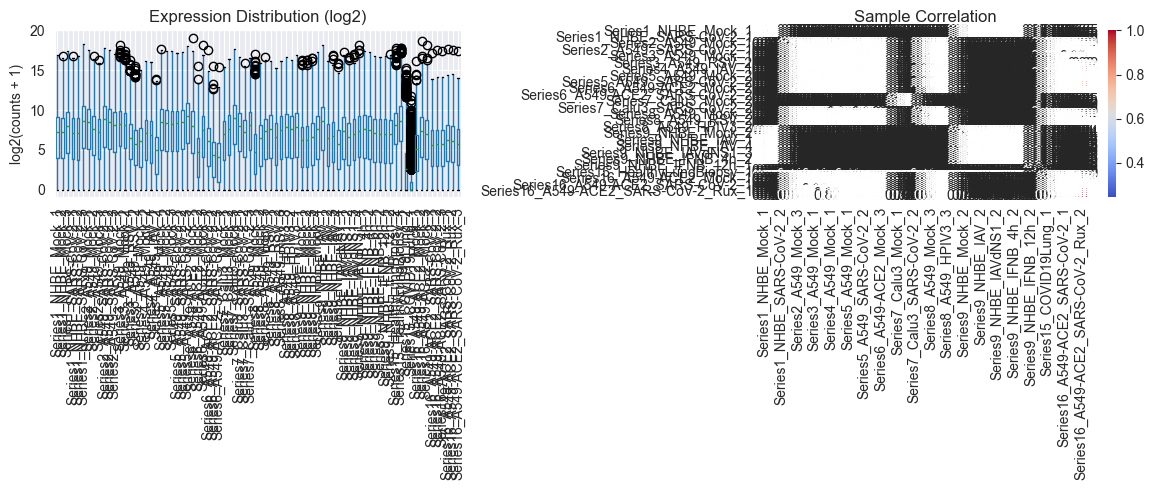

In [7]:
# Filter low-expressed genes (must have >10 reads in at least 3 samples)
expr_filtered = expr_df[(expr_df > 10).sum(axis=1) >= 3]
print(f"Genes after filtering: {expr_filtered.shape[0]}")

# Log2 transform (add pseudocount to avoid log(0))
expr_log2 = np.log2(expr_filtered + 1)

# Create QC plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot of distributions
expr_log2.boxplot(ax=axes[0], rot=90)
axes[0].set_title('Expression Distribution (log2)')
axes[0].set_ylabel('log2(counts + 1)')

# Sample correlation heatmap
corr_matrix = expr_log2.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1])
axes[1].set_title('Sample Correlation')

plt.tight_layout()
plt.savefig('./figures/qc_plots.png', dpi=300, bbox_inches='tight')
print("QC plots saved!")

# Differential Expression Analysis

In [8]:
# Separate infected vs mock samples
# Only "Mock" samples go to mock, only "SARS-CoV-2" (without Mock) go to infected
mock_cols = [col for col in expr_filtered.columns if 'Mock' in col]
infected_cols = [col for col in expr_filtered.columns if 'SARS-CoV-2' in col and col not in mock_cols]

print(f"\nInfected samples ({len(infected_cols)}): {infected_cols}")
print(f"\nMock samples ({len(mock_cols)}): {mock_cols}")

# Verify no overlap
overlap = set(infected_cols) & set(mock_cols)
assert len(overlap) == 0, f"ERROR: Samples in both groups: {overlap}"
print("✓ Samples correctly separated!\n")

infected = expr_filtered[infected_cols]
mock = expr_filtered[mock_cols]

# Calculate statistics for each gene
de_results = []

for gene in expr_filtered.index:
    infected_vals = infected.loc[gene].values
    mock_vals = mock.loc[gene].values

    # Calculate means with pseudocount
    mean_infected = np.mean(infected_vals) + 1
    mean_mock = np.mean(mock_vals) + 1

    fold_change = mean_infected / mean_mock
    log2fc = np.log2(fold_change)

    # T-test
    t_stat, p_value = stats.ttest_ind(infected_vals, mock_vals)

    de_results.append({
        'Gene': gene,
        'Mean_Infected': mean_infected,
        'Mean_Mock': mean_mock,
        'FoldChange': fold_change,
        'Log2FC': log2fc,
        'P_value': p_value
    })

# Create results dataframe
de_df = pd.DataFrame(de_results)

# Remove any infinite or NaN values
de_df = de_df.replace([np.inf, -np.inf], np.nan).dropna()
print(f"Genes after removing inf/nan: {len(de_df)}")

# Adjust p-values
de_df['Adjusted_P'] = multipletests(de_df['P_value'], method='fdr_bh')[1]
de_df['-log10(p)'] = -np.log10(de_df['Adjusted_P'])

# Classify genes
de_df['Regulation'] = 'Not Significant'
de_df.loc[(de_df['Log2FC'] > 1) & (de_df['Adjusted_P'] < 0.05), 'Regulation'] = 'Up'
de_df.loc[(de_df['Log2FC'] < -1) & (de_df['Adjusted_P'] < 0.05), 'Regulation'] = 'Down'

print("\n" + "="*50)
print("DIFFERENTIAL EXPRESSION RESULTS")
print("="*50)
print(de_df['Regulation'].value_counts())
print(f"\nTop 10 upregulated:")
print(de_df[de_df['Regulation'] == 'Up'].nlargest(10, 'Log2FC')[['Gene', 'Log2FC', 'Adjusted_P']])

de_df.to_csv('./results/differential_expression_results.csv', index=False)
print("\n✅ Results saved!")


Infected samples (21): ['Series1_NHBE_SARS-CoV-2_1', 'Series1_NHBE_SARS-CoV-2_2', 'Series1_NHBE_SARS-CoV-2_3', 'Series2_A549_SARS-CoV-2_1', 'Series2_A549_SARS-CoV-2_2', 'Series2_A549_SARS-CoV-2_3', 'Series5_A549_SARS-CoV-2_1', 'Series5_A549_SARS-CoV-2_2', 'Series5_A549_SARS-CoV-2_3', 'Series6_A549-ACE2_SARS-CoV-2_1', 'Series6_A549-ACE2_SARS-CoV-2_2', 'Series6_A549-ACE2_SARS-CoV-2_3', 'Series7_Calu3_SARS-CoV-2_1', 'Series7_Calu3_SARS-CoV-2_2', 'Series7_Calu3_SARS-CoV-2_3', 'Series16_A549-ACE2_SARS-CoV-2_1', 'Series16_A549-ACE2_SARS-CoV-2_2', 'Series16_A549-ACE2_SARS-CoV-2_3', 'Series16_A549-ACE2_SARS-CoV-2_Rux_1', 'Series16_A549-ACE2_SARS-CoV-2_Rux_2', 'Series16_A549-ACE2_SARS-CoV-2_Rux_3']

Mock samples (29): ['Series1_NHBE_Mock_1', 'Series1_NHBE_Mock_2', 'Series1_NHBE_Mock_3', 'Series2_A549_Mock_1', 'Series2_A549_Mock_2', 'Series2_A549_Mock_3', 'Series3_A549_Mock_1', 'Series3_A549_Mock_2', 'Series4_A549_Mock_1', 'Series4_A549_Mock_2', 'Series5_A549_Mock_1', 'Series5_A549_Mock_2', 'Se

In [9]:
# Check your DE results
print("\n" + "="*60)
print("YOUR FINAL DIFFERENTIAL EXPRESSION RESULTS")
print("="*60)
print(f"Total genes analyzed: {len(de_df)}")
print(f"\nDifferentially Expressed Genes (|Log2FC| > 1, adj.p < 0.05):")
print(de_df['Regulation'].value_counts())
print(f"\n📊 SUMMARY:")
print(f"   Upregulated: {sum(de_df['Regulation'] == 'Up')} genes")
print(f"   Downregulated: {sum(de_df['Regulation'] == 'Down')} genes")
print(f"   Not significant: {sum(de_df['Regulation'] == 'Not Significant')} genes")


YOUR FINAL DIFFERENTIAL EXPRESSION RESULTS
Total genes analyzed: 15419

Differentially Expressed Genes (|Log2FC| > 1, adj.p < 0.05):
Regulation
Not Significant    15294
Up                   125
Name: count, dtype: int64

📊 SUMMARY:
   Upregulated: 125 genes
   Downregulated: 0 genes
   Not significant: 15294 genes


In [10]:
# Check genes with negative fold changes
print(f"\nGenes with Log2FC < -1: {sum(de_df['Log2FC'] < -1)}")
print(f"Genes with Log2FC < -1 AND adj.p < 0.05: {sum((de_df['Log2FC'] < -1) & (de_df['Adjusted_P'] < 0.05))}")
print(f"\nMost downregulated genes (even if not significant):")
print(de_df.nsmallest(10, 'Log2FC')[['Gene', 'Log2FC', 'Adjusted_P', 'Regulation']])


Genes with Log2FC < -1: 269
Genes with Log2FC < -1 AND adj.p < 0.05: 0

Most downregulated genes (even if not significant):
          Gene    Log2FC  Adjusted_P       Regulation
1748   ANXA8L1 -5.967773    0.739658  Not Significant
1747     ANXA8 -5.344143    0.738815  Not Significant
8529       MAL -4.318691    0.821400  Not Significant
12041   SPINK7 -3.836712    0.846058  Not Significant
15355   MAGEA6 -3.758830    0.885276  Not Significant
14461    CBWD5 -3.597346    0.823113  Not Significant
5601     CDH16 -3.577405    0.720141  Not Significant
7538    PRODH2 -3.369526    0.858969  Not Significant
3607       NTS -3.231955    0.841490  Not Significant
4138        F7 -3.190439    0.849341  Not Significant


In [11]:
# Debug checks
print(f"\nDE Results shape: {de_df.shape}")
print(f"Log2FC range: {de_df['Log2FC'].min()} to {de_df['Log2FC'].max()}")
print(f"P-value range: {de_df['P_value'].min()} to {de_df['P_value'].max()}")
print(f"-log10(p) range: {de_df['-log10(p)'].min()} to {de_df['-log10(p)'].max()}")
print(f"\nAny inf or nan values?")
print(f"Log2FC inf: {np.isinf(de_df['Log2FC']).sum()}")
print(f"Log2FC nan: {de_df['Log2FC'].isna().sum()}")
print(f"-log10(p) inf: {np.isinf(de_df['-log10(p)']).sum()}")
print(f"-log10(p) nan: {de_df['-log10(p)'].isna().sum()}")
print(f"\nFirst few rows of DE results:")
print(de_df[['Gene', 'Log2FC', 'P_value', 'Adjusted_P', '-log10(p)', 'Regulation']].head(10))


DE Results shape: (15419, 9)
Log2FC range: -5.967772837755541 to 7.971166401039518
P-value range: 4.10496936284035e-08 to 1.0
-log10(p) range: -0.0 to 3.198633871421404

Any inf or nan values?
Log2FC inf: 0
Log2FC nan: 0
-log10(p) inf: 0
-log10(p) nan: 0

First few rows of DE results:
           Gene    Log2FC   P_value  Adjusted_P  -log10(p)       Regulation
0        WASH7P -0.648395  0.089511    0.745222   0.127714  Not Significant
1     LOC729737  0.085363  0.898208    0.994588   0.002357  Not Significant
2  LOC100133331 -0.201229  0.639737    0.974484   0.011225  Not Significant
3  LOC100288069  0.500549  0.194287    0.864966   0.063001  Not Significant
4     LINC00115  1.321928  0.002257    0.128440   0.891299  Not Significant
5        SAMD11 -0.896974  0.193338    0.864033   0.063470  Not Significant
6         NOC2L -0.419470  0.207339    0.874254   0.058362  Not Significant
7        KLHL17 -0.499037  0.191305    0.863369   0.063803  Not Significant
8       PLEKHN1 -0.242060  0.

# Volcano Plot


✅ Volcano plot saved! Found 125 upregulated and 0 downregulated genes!


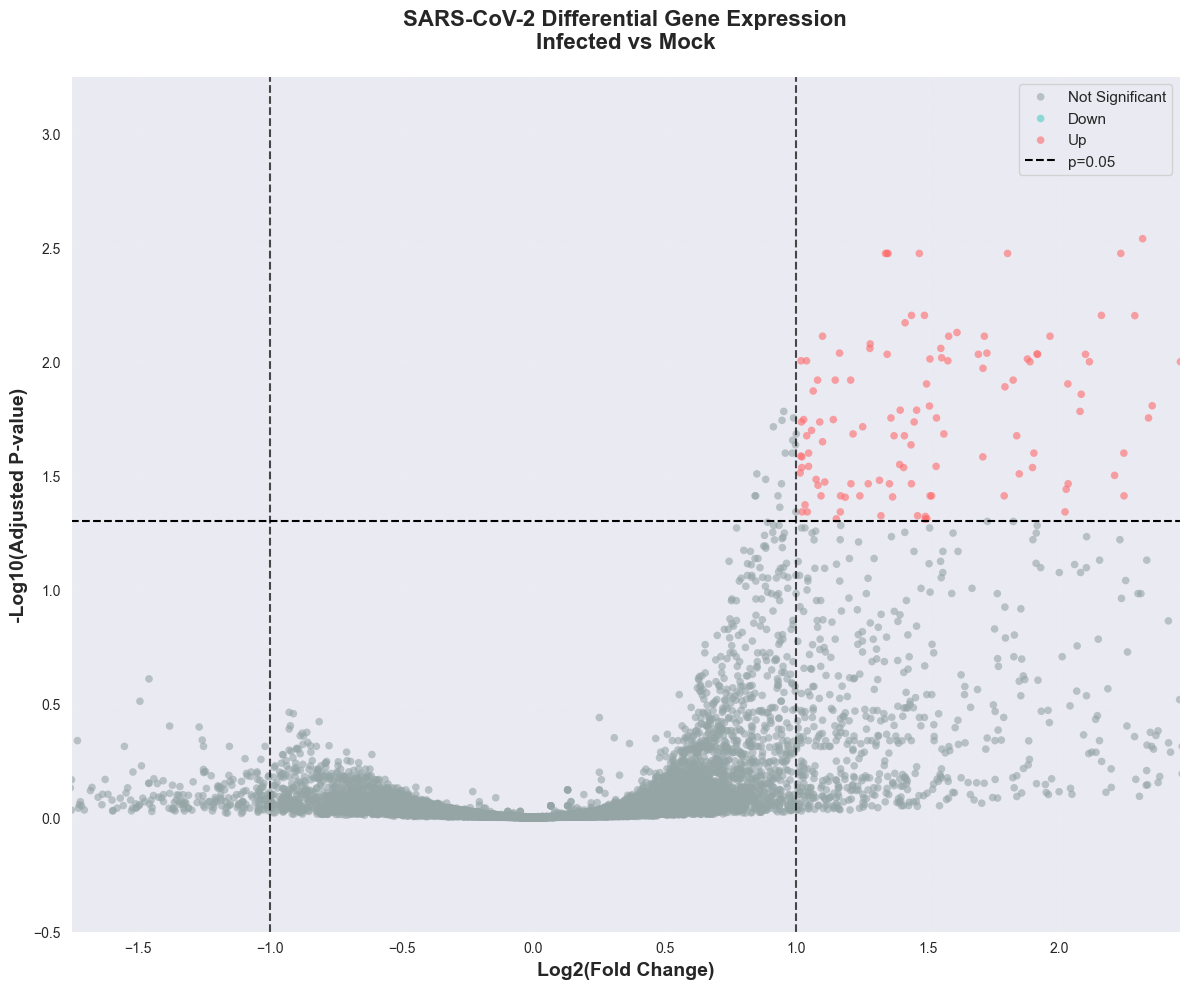

In [16]:
import warnings
warnings.filterwarnings('ignore')  # Suppress font warnings

from adjustText import adjust_text

# Create volcano plot with better scaling
fig, ax = plt.subplots(figsize=(12, 10))

# Define colors
colors = {'Up': '#FF6B6B', 'Down': '#4ECDC4', 'Not Significant': '#95A5A6'}

# Plot each group
for regulation in ['Not Significant', 'Down', 'Up']:  # Plot non-sig first so sig points are on top
    subset = de_df[de_df['Regulation'] == regulation]
    ax.scatter(subset['Log2FC'], subset['-log10(p)'],
               c=colors[regulation], label=regulation, alpha=0.6, s=30,
               edgecolors='none')

# Add threshold lines
ax.axhline(y=-np.log10(0.05), color='black', linestyle='--', linewidth=1.5, label='p=0.05')
ax.axvline(x=1, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax.axvline(x=-1, color='black', linestyle='--', linewidth=1.5, alpha=0.7)

# Set reasonable axis limits
ax.set_xlim(de_df['Log2FC'].quantile(0.01) - 0.5, de_df['Log2FC'].quantile(0.99) + 0.5)
ax.set_ylim(-0.5, de_df['-log10(p)'].quantile(0.99) + 2)

# Labels and styling - using regular text instead of subscripts
ax.set_xlabel('Log2(Fold Change)', fontsize=14, fontweight='bold')
ax.set_ylabel('-Log10(Adjusted P-value)', fontsize=14, fontweight='bold')
ax.set_title('SARS-CoV-2 Differential Gene Expression\nInfected vs Mock',
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', frameon=True, fontsize=11)
ax.grid(True, alpha=0.2, linestyle=':')

plt.tight_layout()
plt.savefig('./figures/volcano_plot.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Volcano plot saved! Found {sum(de_df['Regulation']=='Up')} upregulated and {sum(de_df['Regulation']=='Down')} downregulated genes!")
plt.show()

# Summary Statistics

In [13]:
# Create summary report
with open('./results/analysis_summary.txt', 'w') as f:
    f.write("SARS-CoV-2 Differential Expression Analysis Summary\n")
    f.write("="*60 + "\n\n")
    f.write(f"Dataset: GSE147507\n")
    f.write(f"Total genes analyzed: {len(de_df)}\n\n")
    f.write("Differentially Expressed Genes (|Log2FC| > 1, adj.p < 0.05):\n")
    f.write(f"  - Upregulated: {sum(de_df['Regulation'] == 'Up')}\n")
    f.write(f"  - Downregulated: {sum(de_df['Regulation'] == 'Down')}\n")
    f.write(f"  - Not significant: {sum(de_df['Regulation'] == 'Not Significant')}\n\n")

    f.write("Top 10 Upregulated Genes:\n")
    top_up = de_df[de_df['Regulation'] == 'Up'].nlargest(10, 'Log2FC')
    for _, row in top_up.iterrows():
        f.write(f"  {row['Gene']}: Log2FC={row['Log2FC']:.2f}, adj.p={row['Adjusted_P']:.2e}\n")

    f.write("\nTop 10 Downregulated Genes:\n")
    top_down = de_df[de_df['Regulation'] == 'Down'].nsmallest(10, 'Log2FC')
    for _, row in top_down.iterrows():
        f.write(f"  {row['Gene']}: Log2FC={row['Log2FC']:.2f}, adj.p={row['Adjusted_P']:.2e}\n")

print("Summary report saved!")

Summary report saved!


In [14]:
print(f"Expression data shape: {expr_log2.shape}")
print(f"Sample columns: {expr_log2.columns.tolist()}")
print(f"Any data? {expr_log2.values.sum()}")

Expression data shape: (15427, 78)
Sample columns: ['Series1_NHBE_Mock_1', 'Series1_NHBE_Mock_2', 'Series1_NHBE_Mock_3', 'Series1_NHBE_SARS-CoV-2_1', 'Series1_NHBE_SARS-CoV-2_2', 'Series1_NHBE_SARS-CoV-2_3', 'Series2_A549_Mock_1', 'Series2_A549_Mock_2', 'Series2_A549_Mock_3', 'Series2_A549_SARS-CoV-2_1', 'Series2_A549_SARS-CoV-2_2', 'Series2_A549_SARS-CoV-2_3', 'Series3_A549_Mock_1', 'Series3_A549_Mock_2', 'Series3_A549_RSV_1', 'Series3_A549_RSV_2', 'Series4_A549_Mock_1', 'Series4_A549_Mock_2', 'Series4_A549_IAV_1', 'Series4_A549_IAV_2', 'Series5_A549_Mock_1', 'Series5_A549_Mock_2', 'Series5_A549_Mock_3', 'Series5_A549_SARS-CoV-2_1', 'Series5_A549_SARS-CoV-2_2', 'Series5_A549_SARS-CoV-2_3', 'Series6_A549-ACE2_Mock_1', 'Series6_A549-ACE2_Mock_2', 'Series6_A549-ACE2_Mock_3', 'Series6_A549-ACE2_SARS-CoV-2_1', 'Series6_A549-ACE2_SARS-CoV-2_2', 'Series6_A549-ACE2_SARS-CoV-2_3', 'Series7_Calu3_Mock_1', 'Series7_Calu3_Mock_2', 'Series7_Calu3_Mock_3', 'Series7_Calu3_SARS-CoV-2_1', 'Series7_Cal

In [15]:
print(f"Infected samples ({len(infected_cols)}): {infected_cols}")
print(f"Mock samples ({len(mock_cols)}): {mock_cols}")
print("\nRegulation counts:")
print(de_df['Regulation'].value_counts())
print(f"\nHow many genes with adj.p < 0.05? {sum(de_df['Adjusted_P'] < 0.05)}")
print(f"How many genes with |Log2FC| > 1? {sum(abs(de_df['Log2FC']) > 1)}")

Infected samples (21): ['Series1_NHBE_SARS-CoV-2_1', 'Series1_NHBE_SARS-CoV-2_2', 'Series1_NHBE_SARS-CoV-2_3', 'Series2_A549_SARS-CoV-2_1', 'Series2_A549_SARS-CoV-2_2', 'Series2_A549_SARS-CoV-2_3', 'Series5_A549_SARS-CoV-2_1', 'Series5_A549_SARS-CoV-2_2', 'Series5_A549_SARS-CoV-2_3', 'Series6_A549-ACE2_SARS-CoV-2_1', 'Series6_A549-ACE2_SARS-CoV-2_2', 'Series6_A549-ACE2_SARS-CoV-2_3', 'Series7_Calu3_SARS-CoV-2_1', 'Series7_Calu3_SARS-CoV-2_2', 'Series7_Calu3_SARS-CoV-2_3', 'Series16_A549-ACE2_SARS-CoV-2_1', 'Series16_A549-ACE2_SARS-CoV-2_2', 'Series16_A549-ACE2_SARS-CoV-2_3', 'Series16_A549-ACE2_SARS-CoV-2_Rux_1', 'Series16_A549-ACE2_SARS-CoV-2_Rux_2', 'Series16_A549-ACE2_SARS-CoV-2_Rux_3']
Mock samples (29): ['Series1_NHBE_Mock_1', 'Series1_NHBE_Mock_2', 'Series1_NHBE_Mock_3', 'Series2_A549_Mock_1', 'Series2_A549_Mock_2', 'Series2_A549_Mock_3', 'Series3_A549_Mock_1', 'Series3_A549_Mock_2', 'Series4_A549_Mock_1', 'Series4_A549_Mock_2', 'Series5_A549_Mock_1', 'Series5_A549_Mock_2', 'Seri